# Weather and Electric Load Forecasting <br/> ... (from scratch) with Python Data Science Tools
* * * * 

**Nelson Correa, *Ph.D.*** <br/>
*NLP, Data Science and Machine Learning* <br/>
West Palm Beach, FL <br/>
[@nelscorrea](https://twitter.com/nelscorrea)
Jan. 10, 2019


<hr/>
* * * * 
**PyData Miami 2019**, Jan. 9-11, 2019



# PyData Part II - Electric Load Forecasting


# Outline: 

#### Python data science tools

#### Weather forecasting
* Datasets (NOAA)
* Visualization & description
* Features, models, seasonality (yearly); model evaluation

#### Electric load forecasting
* Datasets (GEFCON2012 Load)
* Visualization & analysis
* Features and models, seasonality (yearly, daily); model evaluation

#### Conclusion
* Other models and further work



<hr/>
### Data source and references


**GEFCON2012 & Dr. Tao Hong**, UNC Charlotte, NC
* http://www.gefcom.org
[@DrHongTao](https://twitter.com/DrHongTao)



### Global Energy Forecasting Competition 2012 (GEFCom2012)

* IEEE Power Engineering Society, General Meeting 2013, Vancouver, Canada 
* Kaggle competition: two months, 8/31/2012 - 10/31/2012,

### References

Hong, T., Pinson, P., & Fan, S. (2014). Global energy forecasting competition 2012. *International Journal of
Forecasting*, 30(2), 357-363.

GEFCom2012: Global Energy Forecasting Competition 2012, 
Tao Hong, Pierre Pinson, Shu Fan, HSC/13/16.

<hr/>


## IEEE GEFCOM2012 Data Files


### Hierarchical load forecasting track

Forecast hourly loads (in kW) for a US utility with 20 zones at both the zonal (20 series) and system (sum of the 20 zonal level series) levels, with a total of 21 series.

NOTE: GEFCOM2012 included a separate *Wind power forecasting* track, not considered here.

### Data
* 20 zonal load zones (20 series)
* 1 system zone (sum of the 20 zonal level series)
* 4.5 years of hourly load and temperature history data; eight non-consecutive weeks of load data removed.

### Task
* Predict the loads for the week immediately after the 4.5 years of history, without the actual temperatures or temperature forecasts being given.



### LOAD files

    Load_history.csv (33,001 records, 20 load zones; does not include system zone)
    Load_benchmark.csv (1324 records, 21 load zones)
    Load_solution.csv (1324 records, 21 load zones)
    Temperature_history.csv (18074 records; 11 weather stations)
    Temperature_solution.csv (2047 records)
    Holiday_List.csv (US holidays)


In [2]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
# Read Load solution data: load_solution_df.csv
load_history_df = pd.read_csv("GEFCOM2012_ieee/Load/Load_history.csv", sep=',')
print("load_history_df.shape:", load_history_df.shape)
print("load_history_df.columns:", load_history_df.columns)
load_history_df.head(3)

load_history_df.shape: (33000, 28)
load_history_df.columns: Index(['zone_id', 'year', 'month', 'day', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6',
       'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
       'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24'],
      dtype='object')


,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,"16,853","16,450","16,517","16,873","17,064","17,727",...,"13,518","13,138","14,130","16,809","18,150","18,235","17,925","16,904","16,162","14,750"
1,1,2004,1,2,"14,155","14,038","14,019","14,489","14,920","16,072",...,"16,127","15,448","15,839","17,727","18,895","18,650","18,443","17,580","16,467","15,258"
2,1,2004,1,3,"14,439","14,272","14,109","14,081","14,775","15,491",...,"13,507","13,414","13,826","15,825","16,996","16,394","15,406","14,278","13,315","12,424"


### Load history data wrangling
* File `Load_history.csv` has load numbers as strings; convert to int64
* File `Load_history.csv` has 9 missing weeks of data, for backcasting and for forecasting.
* Load for hourly data appears in columns `h1` to `h24`; unpivot (pandas.melt()) to create time series index.
* Load for 21 zones appears as individual records, per `zone_id`; pivot on `zone_id`.


In [4]:
# Convert h1-h24 load number strings to int64 (remove format commas, NAs, etc)
load_history_df = load_history_df.replace(regex=r',', value='')
load_history_df = load_history_df.dropna()
load_history_df = load_history_df.astype('int64')
print("load_history_df.shape:", load_history_df.shape)
load_history_df.head(3)

load_history_df.shape: (31720, 28)


,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,16853,16450,16517,16873,17064,17727,...,13518,13138,14130,16809,18150,18235,17925,16904,16162,14750
1,1,2004,1,2,14155,14038,14019,14489,14920,16072,...,16127,15448,15839,17727,18895,18650,18443,17580,16467,15258
2,1,2004,1,3,14439,14272,14109,14081,14775,15491,...,13507,13414,13826,15825,16996,16394,15406,14278,13315,12424


In [5]:
# Load history hourly - Unpivot h1-h24 columns (pandas.melt())
load_hours = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 
        'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']
load_history_vars = ['zone_id', 'year', 'month', 'day']
load_history_df_hourly = load_history_df.melt(id_vars=load_history_vars, 
                                value_vars=load_hours, var_name='hour', value_name='load')

# Convert h1-h24 'hour' values to 0-23 int values
load_history_df_hourly['hour'] = load_history_df_hourly['hour'].str.replace('h', '').astype('int64') - 1

print("load_history_df_hourly.shape:", load_history_df_hourly.shape)
print("load_history_df_hourly.columns:", load_history_df_hourly.columns)

load_history_df_hourly.shape: (761280, 6)
load_history_df_hourly.columns: Index(['zone_id', 'year', 'month', 'day', 'hour', 'load'], dtype='object')


### Hourly time series: Pivot `zone_id` and reindex load history

#### Convert hierarchical time series index to Datetime

* year, month, day, hour
* load_history_df_data

<hr/>


In [6]:
# Pivot zone_id and reindex with date_index
date_index = ['year', 'month', 'day', 'hour']
load_history_df_data = load_history_df_hourly.pivot_table(index=date_index,  
                               columns='zone_id', values='load', aggfunc='sum', fill_value=0)

print("load_history_df_data.shape:", load_history_df_data.shape)
print("load_history_df_data.columns:", load_history_df_data.columns)
load_history_df_data.head(3)

load_history_df_data.shape: (38064, 20)
load_history_df_data.columns: Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20],
           dtype='int64', name='zone_id')


zone_id                 1       2       3    4     5       6       7     8   \
year month day hour                                                           
2004 1     1   0     16853  126259  136233  484  6829  133088  136233  3124   
               1     16450  123313  133055  457  6596  129909  133055  2956   
               2     16517  119192  128608  450  6525  125717  128608  2953   

zone_id                 9      10     11      12     13     14     15     16  \
year month day hour                                                            
2004 1     1   0     75243  23339  90700  118378  20673  21791  65970  28752   
               1     67368  22100  86699  112480  19666  21400  64600  27851   
               2     64050  21376  84243  108435  19020  20998  63843  27631   

zone_id                 17      18     19     20  
year month day hour                               
2004 1     1   0     30645  200946  82298  79830  
               1     30461  195835  79827  77429  
               2     30197  194093  77728  75558

In [7]:
print("load_history_df_data.index len:", len(load_history_df_data.index))
print("load_history_df_data.index.nlevels:", load_history_df_data.index.nlevels)

# Reindex load_history_df_data with hierarchical index (year, month, day, hour) 
# to time series with datetime index
load_history_df_index_dt = [datetime(y,m,d,h) for (y,m,d,h) in load_history_df_data.index]
load_history_df_data.index = load_history_df_index_dt
load_history_df_data[[1,2,3,20]].head(3)

load_history_df_data.index len: 38064
load_history_df_data.index.nlevels: 4


zone_id,1,2,3,20
2004-01-01 00:00:00,16853,126259,136233,79830
2004-01-01 01:00:00,16450,123313,133055,77429
2004-01-01 02:00:00,16517,119192,128608,75558


In [8]:
# Add aggregate system zone 21 to load history
load_history_df_data[21] = load_history_df_data.sum(axis=1)
load_history_df_data[[1,2,20,21]].describe()

zone_id,1,2,20,21
count,38064.000000,38064.000000,38064.000000,3.806400e+04
mean,18641.241488,173748.222730,88649.680223,1.647167e+06
std,5796.667521,34996.374374,18654.775828,3.746085e+05
min,7319.000000,82672.000000,46291.000000,8.369000e+05
25%,14415.000000,149160.500000,75384.000000,1.383689e+06
50%,17349.500000,170451.500000,86771.000000,1.586182e+06
75%,22024.250000,196107.750000,100715.000000,1.885652e+06
max,45547.000000,321509.000000,176705.000000,3.280423e+06


### Load history per zone

* Aggregate system load: zone 21, 1.58 GW mean
* Largest zone load: zone 18, 205 MW mean, 540 MW peak
* Smallest zone load: zone 4, 480 kW mean, 1.1 MW peak



### Visualization: Load history, 4.5 years, aggregate system (zone 21)

Electric load of 20 different zones (zone_ids 1-20), plus aggregate total zone_id 21

* 4.5 years of data: date range 01/01/2004 (00:00AM) to 06/30/2008 (06:00 AM)
* 224 Weeks; 9 deleted weeks 1-8 backcast; 1 week forecast


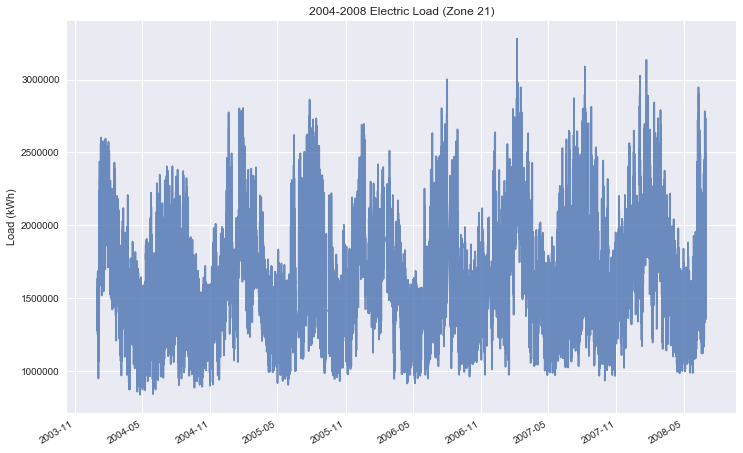

In [9]:
# Visualize: load_history_df_data, Total zone_id 21; 224 weeks
title = '2004-2008 Electric Load (Zone 21)'
load_history_df_data[:][21].plot(alpha=0.8, title=title, figsize=(12,8));
plt.ylabel('Load (kWh)');

### Aggregate system load (zone 21)

Yearly seasonal pattern clearly visible, with load lows in [April, October] and load highs in [January, July].
- Hypothesis: load lows after equinox times of Spring and Fall.
- Hypothesis: load peaks in Summer and Winter.

High daily load variation
* Filter out with moving average (MA) - e.g., 2 day

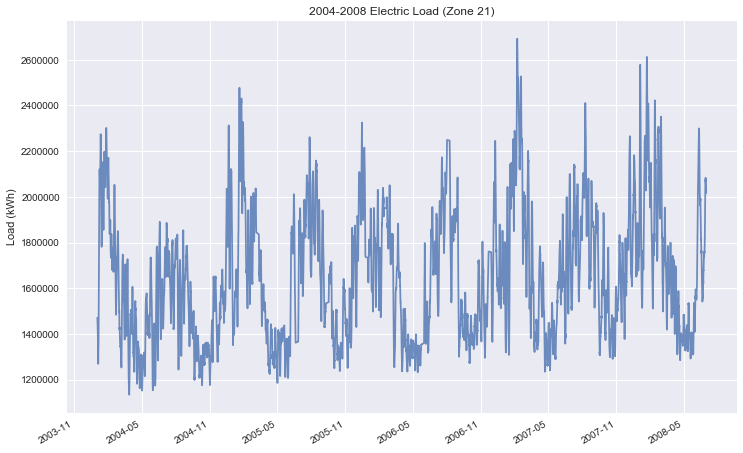

In [10]:
# Visualize: 48 hour moving average (MA) - filter out daily variation
load_history_df_data[:][21].rolling(48).mean().plot(alpha=0.8, title=title, figsize=(12,8));
plt.ylabel('Load (kWh)');

### Load history, weekly view, aggregate system load (21)

* Last two weeks of load history period (06/17-30/2008)
* First week of load history period


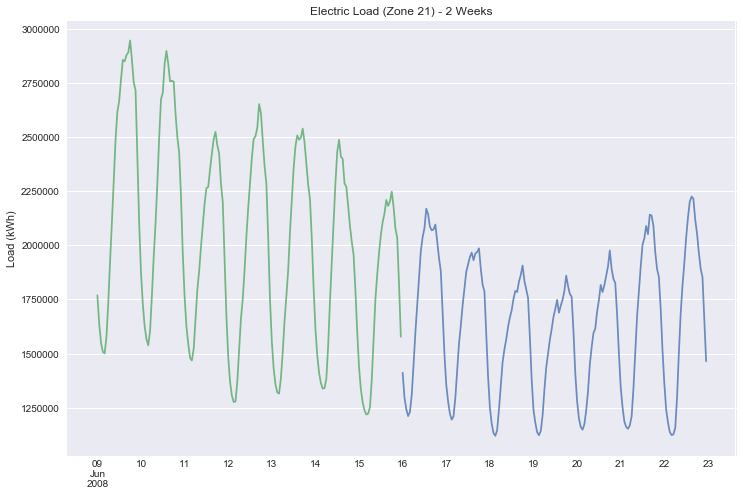

In [11]:
# Visualize: load_history_df_data, Total zone_id 21; 2 weeks
title = 'Electric Load (Zone 21) - 2 Weeks'
load_history_df_data[-168*2:-168][21].plot(alpha=0.8, title=title, figsize=(12,8));
load_history_df_data[-168*3:-168*2][21].plot(alpha=0.8, title=title, figsize=(12,8));
plt.ylabel('Load (kWh)');

### Load history, weekly view, aggregate system load (21)

Intra-day hourly pattern clearly visible, with load lows around 1AM and highs around 12N.

* Peak daily load ~ 2.5 GWh
* Low  daily load ~ 1.2 GWh
* Last day of history period is 06/30/2008

<hr/>
### Load history, weekly view, zones 1-20

* Last two weeks of load history period (06/17-30/2008)


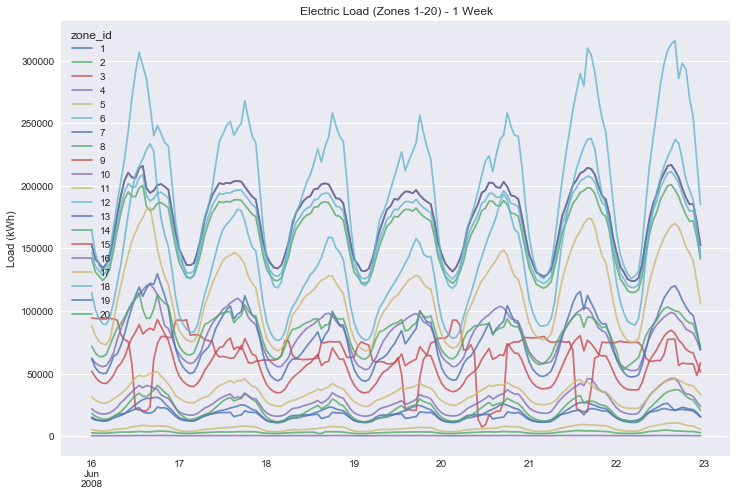

In [28]:
# Visualize: load_history_df_data, Total load zone_ids 1-20; 1 week
# Zone 4 has 500 kWh; zone 18 reaches 400,000 kWh
local_zones = np.arange(1,21)
title='Electric Load (Zones 1-20) - 1 Week'
load_history_df_data[-168*2:-168][local_zones].plot(alpha=0.8, title=title, figsize=(12,8));
plt.ylabel('Load (kWh)');

### Load history, weekly view, individual zones 1-20

Intra-day hourly pattern clearly visible, with load lows around 1AM and highs around 12N.

* Peak daily load: zone 18, 205 kW mean, 540 kW peak
* Low  daily load: zone 4, 0.48 kW mean, 1.1 kW peak
* Zone 9 is an industrial zone; has inverted load demand phase w.r.t. other zones



# Electric Load Forecasting - Data Model

We consider here a baseline Linear Regression model, with time series seasonality features.

### sklearn.linear_models.LinearRegression()

* Year seasonality (twice year frequency), sin(182.625 days)
* Hour seasonality, sin(24 hours)
* Day of the week (SMTWTFS), weekly seasonality
* Calendar holidays, yearly seasonality, holidays()

#### Model input features
* Temperature prediction as a function of time (DATE) and previous temperature only 
* train on historical data (e.g., past 10, 30, 50, 70 years)

#### Length of forecast period (length of test period)
* multi-year test period
* 1-10 day test period

<hr/>


In [13]:
# imports
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [14]:
# models
model_load = LinearRegression(fit_intercept=True)
model_load_polynomial = make_pipeline(PolynomialFeatures(3), LinearRegression())


### Linear Prediction Model, Yearly and daily seasonality

* Training data: 2004-01-01 to 2008-06-30 (4.5 years)
* Test data: 2008-07-01 to 2008-07-07 (1 week)

### Seasonality features

* Yearly seasonality feature, one year period, with phase delay
* Daily seasonality feature, one day period, with phase delay
* Model input features: data index 'DATE', 'SEASON', 'DAY'

<hr/>


In [15]:
# Make yearly season signal: yearly season variation, with phase delay
def season_year(date):
    """Compute yearly season signal for input date"""
    period = 182.625  # period in days
    phase_lag = -125   # lag in days
    days = (date - pd.datetime(1900, 12, 21)).days
    m = np.cos((days + phase_lag) * 2 * np.pi / period)
    return 0.0 + 5e5 * np.degrees(-m) / 180.

load_history_season = load_history_df_data.copy()
load_history_season['Season'] = list(map(season_year, load_history_season.index))
load_history_season[[21, 'Season']].head(3)

zone_id,21,Season
2004-01-01 00:00:00,1397668,110155.537334
2004-01-01 01:00:00,1351507,110155.537334
2004-01-01 02:00:00,1315742,110155.537334


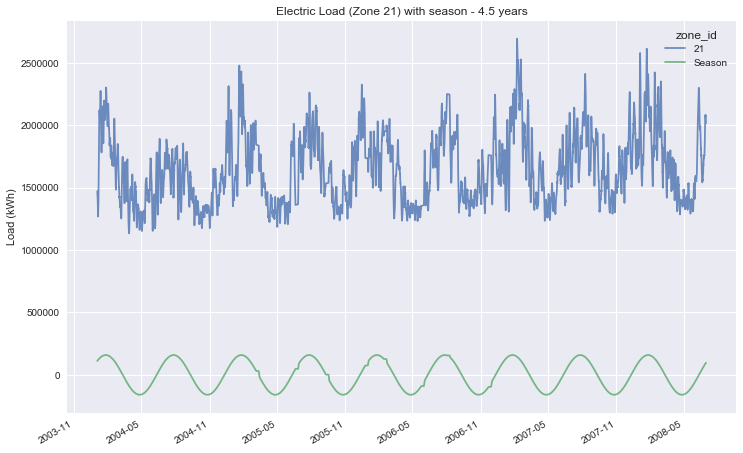

In [26]:
# Visualize system load (21)
title = 'Electric Load (Zone 21) with season - 4.5 years'
load_history_season[[21,'Season']].rolling(48).mean().plot(
                        alpha=0.8, title=title, figsize=(12,8))
plt.ylabel('Load (kWh)');

In [17]:
# Make daily seasonality signal: daily variation date.hour, with phase delay
def season_day(date):
    """Compute season signal for input date"""
    period = 24  # period in hours
    phase_lag = -4   # lag in hours
    m = np.cos((date.hour + phase_lag) * 2 * np.pi / period)
    return 0.0 + 5e5 * np.degrees(-m) / 180.

load_history_season['Daily'] = list(map(season_day, load_history_season.index))
load_history_season[[21, 'Season', 'Daily']].head(3)

zone_id,21,Season,Daily
2004-01-01 00:00:00,1397668,110155.537334,-79577.471546
2004-01-01 01:00:00,1351507,110155.537334,-112539.539520
2004-01-01 02:00:00,1315742,110155.537334,-137832.223855


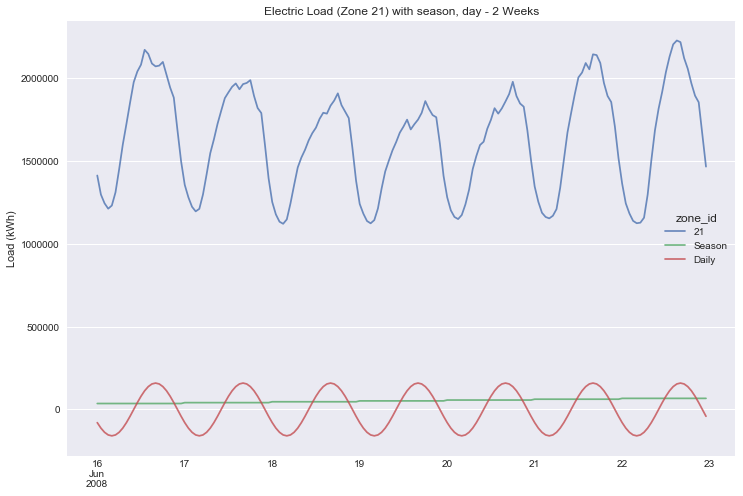

In [18]:
# Visualize system load (21)
title = 'Electric Load (Zone 21) with season, day - 2 Weeks'
load_history_season[-168*2:-168][[21,'Season','Daily']].plot(alpha=0.8, title=title, figsize=(12,8))
plt.ylabel('Load (kWh)');

In [19]:
# Load data with yearly and daily season signal
start_date = '2004-01-01'
end_date = '2008-06-30'
score_dates = load_history_season[start_date:end_date].index
# pd.date_range(start_date, end_date)

X_train = pd.DataFrame(index=score_dates)
# X_train = pd.DataFrame(index=load_history_season[start_date:end_date].index)
X_train['date'] = score_dates[:, np.newaxis].astype('float64') * 1e-17
X_train['season'] = list(map(season_year, score_dates))
X_train['day'] = list(map(season_day, score_dates))

y_train = load_history_season[start_date:end_date][[21]]
X_train.head(3)

,date,season,day
2004-01-01 00:00:00,10.729152,110155.537334,-79577.471546
2004-01-01 01:00:00,10.729188,110155.537334,-112539.539520
2004-01-01 02:00:00,10.729224,110155.537334,-137832.223855


In [20]:
y_train.head(3)

zone_id,21
2004-01-01 00:00:00,1397668
2004-01-01 01:00:00,1351507
2004-01-01 02:00:00,1315742


In [21]:
# Train models (linear only)
X_train_float64 = X_train.astype('float64')
model_load.fit(X_train_float64, y_train)

# Model score and coefficients: X as training date_range()
print("model_load.coef_:", model_load.coef_, "model_load.intercept_:", model_load.intercept_)
print("model_load.score:", model_load.score(X_train, y_train))

model_load.coef_: [[1.47084734e+05 1.72658062e+00 1.18971696e+00]] model_load.intercept_: [-33366.60552771]
model_load.score: 0.4165223085070894


/Users/nelson/Dev/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [22]:
# Run model on training data
load_predict = load_history_season[start_date:end_date]
load_predict['p21'] = model_load.predict(X_train_float64)[:,0]
load_predict[['Season', 'Daily', 21, 'p21']].head(3)

/Users/nelson/Dev/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


zone_id,Season,Daily,21,p21
2004-01-01 00:00:00,110155.537334,-79577.471546,1397668,1.640246e+06
2004-01-01 01:00:00,110155.537334,-112539.539520,1351507,1.601035e+06
2004-01-01 02:00:00,110155.537334,-137832.223855,1315742,1.570950e+06


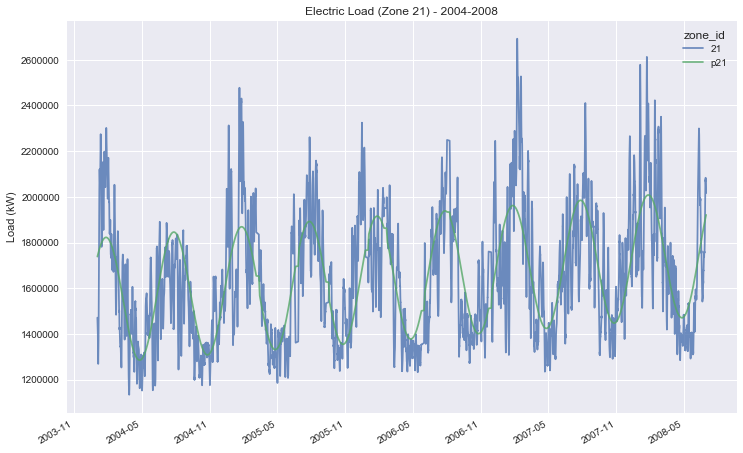

In [27]:
# Plot load_predict on training data
title='Electric Load (Zone 21) - 2004-2008'
load_predict[[21,'p21']].rolling(48).mean().plot(alpha=0.8,figsize=(12,8),title=title);
plt.ylabel('Load (kW)');

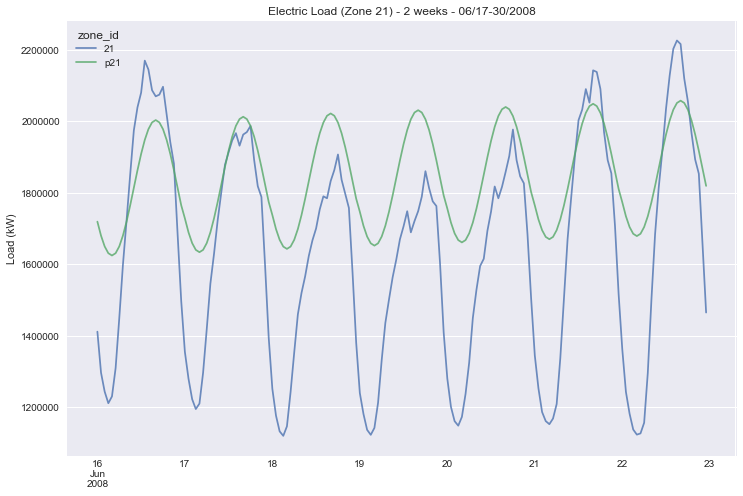

In [24]:
# Plot load_predict on training data
title='Electric Load (Zone 21) - 2 weeks - 06/17-30/2008'
load_predict[-168*2:-168][[21,'p21']].plot(alpha=0.8,figsize=(12,8),title=title);
plt.ylabel('Load (kW)');

In [25]:
# Define prediction error (MSE, RMSE)
def prediction_error(y1, y2):
    """prediction_error(y1, y2): returns MSE and RMSE"""
    if len(y1) != len(y2):
        return (-1, -1)
    mse = (1/len(y1))*np.sum((y1-y2)**2)
    return (mse, np.sqrt(mse))

# Compute prediction error, load Zone 21
_, rmse_load = prediction_error(load_predict[21], load_predict['p21'])
print("rmse_load (kW):", rmse_load)

rmse_load (kW): 286143.5713603093



## Electric load forecasting - *Weekly seasonality and other trends?*

The above linear regression model with yearly and daily seasonality signals has a high electric load prediction error (RMSE).

In addition to yearly and daily seasonality, electric load demand data also exhibits weekly seasonality and other seasonality and demand trends that should be accounted for.

We leave as an exercise:
* Add day-of-the-week as weekly indicator variables ('MON' to 'SUN')
* Add holidays of the year as a yearly indicator variable ('HOLIDAY')

Include weekly indicator variables to the prediction model.

We also leave for another exercise prediction of individual load zones (1-20).

<hr/>


### Residuals of the prediction

The residuals ($y_t - \hat{y}_t$)  of the predictions $\hat{y}_t$ should have:

* zero mean of residuals ($y_t - \hat{y}_t$) 
* zero correlation between the residuals and the observations for the predictor variable

<hr/>



# Summary: Electric Load Prediction



## Model score and error measure (with seasonality)

* model_load.score: 0.2195
* rmse_zone_21: 419 MW, on peak load of ~ 2.5 GW

<hr/>

## Other models/toolkits to explore and further work

We built time-series models with seasonality (yearly and daily) from scratch.
Follow up to this intial work on forecasting include applying traditional models for time-series analysis: exponential smoothing, autoregressive integrated moving average (ARIMA), and seasonal ARIMA models.

Other recent methods include time-series analysis with recurrent neural networks (RNN nd LSTM), autoregressive RNNs, and other recent toolkits for forecasting and time-series analysis.

<hr/>



### Exponential and autoregressive models

* Exponential smoothing models: 
    - https://www.statsmodels.org/dev/generated/statsmodels.tsa..holtwinters.ExponentialSmoothing.html

* Autoregressive Integrated Moving Average (ARIMA) models: 
    - https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html

* Seasonal AutoRegressive Integrated Moving Average (SARIMA) models: 
    - https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html


### Neural network models


* Bandara et al, Forecasting Across Time Series Databases using Recurrent Neural Networks on Groups of Similar Series: A Clustering Approach. Kasun Bandara, Christoph Bergmeir, Slawek Smyl. 
https://arxiv.org/abs/1710.03222

* García-Ascanio et al, Electric power demand forecasting using interval time series: A comparison between VAR and iMLP. Carolina García-Ascanio, Carlos Maté. In Energy Policy, Volume 38, Issue 2, February 2010, Pages 715-725.


### Facebook Prophet - open source forecasting tool

* Facebook Research - Prophet: forecasting at scale (2017)
    - https://research.fb.com/prophet-forecasting-at-scale/



# Conclusion

We have presented baseline linear weather and electric load prediction models with seasonality.

We have outlined more powerful and recent forecasting models for future work.


## Github Jupyter notebooks

* https://github.com/nelscorrea/PyDataMiami2019/

<hr/>
